In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [ ]:
# loading the data
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/AirQualityUCI.csv
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/Dataset%20description.txt

## 1. Data Description
The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. 

The device was located on the field in a significantly polluted area, at road level,within an Italian city. 

Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses.

 Missing values are tagged with -200 value.

**Attribute Information:**
1. **Date** (DD/MM/YYYY)
2. **Time** (HH.MM.SS)
3. **CO** True hourly averaged concentration CO in mg/m^3 (reference analyzer)
4. **PT08.S1** (tin oxide) hourly averaged sensor response (nominally CO targeted)
5. **NMHC** True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
6. **C6H6** True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) -> **Target variable**
7. **PT08.S2** (titania) hourly averaged sensor response (nominally NMHC targeted)
8. **NOx** True hourly averaged NOx concentration in ppb (reference analyzer)
9. **PT08.S3** (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
10. **NO2** True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
11. **PT08.S4** (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
12. **PT08.S5** (indium oxide) hourly averaged sensor response (nominally O3 targeted)
13. **T** Temperature in Â°C
14. **RH** Relative Humidity (%)
15. **AH** Absolute Humidity


## 2. General overview of the data

In [4]:
# reading the data
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']])

In [6]:
# Checkin information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date_Time      9471 non-null   object 
 1   CO(GT)         9357 non-null   float64
 2   PT08.S1(CO)    9357 non-null   float64
 3   NMHC(GT)       9357 non-null   float64
 4   C6H6(GT)       9357 non-null   float64
 5   PT08.S2(NMHC)  9357 non-null   float64
 6   NOx(GT)        9357 non-null   float64
 7   PT08.S3(NOx)   9357 non-null   float64
 8   NO2(GT)        9357 non-null   float64
 9   PT08.S4(NO2)   9357 non-null   float64
 10  PT08.S5(O3)    9357 non-null   float64
 11  T              9357 non-null   float64
 12  RH             9357 non-null   float64
 13  AH             9357 non-null   float64
 14  Unnamed: 15    0 non-null      float64
 15  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(1)
memory usage: 1.2+ MB


In [9]:
# As we have 2 columns with null values only we can delete them
df.drop('Unnamed: 15', axis=1, inplace=True)
df.drop('Unnamed: 16', axis=1, inplace=True)

In [ ]:
# Checking for duplicates
df[df.duplicated(keep='last')]

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9357,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9358,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9359,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9361,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9465,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9466,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Deleting duplicated records
df = df.drop_duplicates()

In [ ]:
# Deleting last one row wich consists from null values only
df.drop(df.tail(1).index,inplace=True)

In [ ]:
# General description of numerical data
# We have min -200 for all columns but from description we know these are nulls
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [ ]:
# Replacing -200.0 with NaN for future preprocessing
df.replace(-200.0, np.nan, inplace=True)

* As we have Date_Time column we need to extract from it useful information

In [ ]:
# Converting Date_Time column to datetime format
df['Date_Time']=pd.to_datetime(df['Date_Time'].astype(str), format='%d/%m/%Y %H.%M.%S')

In [ ]:
# Checking if we have min and sec in time information -> we don't have, only hours
df.Date_Time.dt.time.unique()

array([datetime.time(18, 0), datetime.time(19, 0), datetime.time(20, 0),
       datetime.time(21, 0), datetime.time(22, 0), datetime.time(23, 0),
       datetime.time(0, 0), datetime.time(1, 0), datetime.time(2, 0),
       datetime.time(3, 0), datetime.time(4, 0), datetime.time(5, 0),
       datetime.time(6, 0), datetime.time(7, 0), datetime.time(8, 0),
       datetime.time(9, 0), datetime.time(10, 0), datetime.time(11, 0),
       datetime.time(12, 0), datetime.time(13, 0), datetime.time(14, 0),
       datetime.time(15, 0), datetime.time(16, 0), datetime.time(17, 0)],
      dtype=object)

In [ ]:
# Assigning values about hour, month, year of Date_Time to separate columns
df['Hour'] = df.Date_Time.dt.hour
df['Month'] = df.Date_Time.dt.month
df['Year'] = df.Date_Time.dt.year

In [ ]:
# Changing datatype to category
df.Hour = df.Hour.astype('category')
df.Month = df.Month.astype('category')
df.Year = df.Year.astype('category')

In [ ]:
# Now we can drop Date_Time column as all useful information was extracted
del df['Date_Time']

## 3. Univariate analysis

Before analysis itself let's create some functions for plotting

In [ ]:
# Helping function for plotting
def plot1(column, ax):
    sns.countplot(x = column, data = df, ax = ax)
    ax.set_xlabel(column.title())
    ax.set_ylabel("Count")
    ax.set_title(f'{column.title()} Count')
    
# Function for 3 plots visualization
def plot3(column1, column2, column3):
  fig, [ax1, ax2, ax3] = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 18))
  plot1(column1, ax1)
  plot1(column2, ax2)
  plot1(column3, ax3)
    

### 3.1. Target 
Let's check what we have for C6H6(GT) variable.

In [ ]:
# Checking percentage of null values
df['C6H6(GT)'].isna().sum()/len(df)

0.0391151009939083

In [ ]:
# dropping rows where target is null
df = df[df['C6H6(GT)'].notna()]

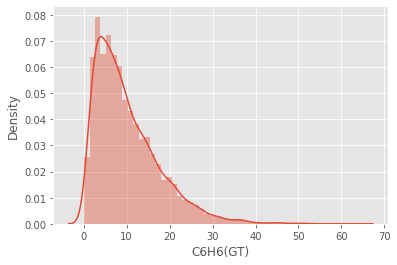

In [ ]:
# Visualization for target variable
sns.distplot(df['C6H6(GT)'])

From histogram we can see that target variable:
* Deviates from the normal distribution
* Has appreciable positive skewness
* Shows peakedness
* Has outliers

And we can check this with numbers

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df['C6H6(GT)'].skew())
print("Kurtosis: %f" % df['C6H6(GT)'].kurt())

Skewness: 1.361532
Kurtosis: 2.488706


Lets' try some kinds of transformation to see how it will impact target variable

In [ ]:
# log, power(2) and squre root transformation of target 
log_target = np.log(df['C6H6(GT)'])
power_target = np.power(df['C6H6(GT)'], 2)
sqrt_target = np.sqrt(df['C6H6(GT)'])

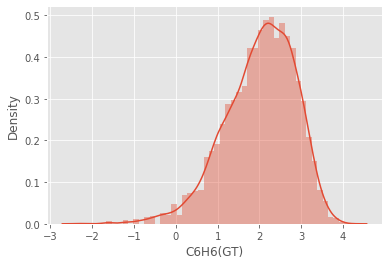

In [ ]:
# Visualization for log transformation of target
sns.distplot(log_target)

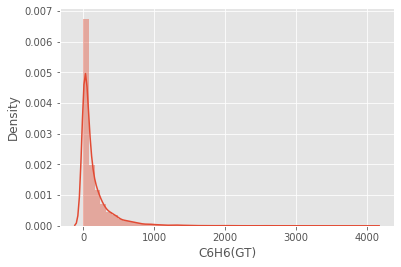

In [ ]:
# Visualization for power(2) transformation of target
sns.distplot(power_target)

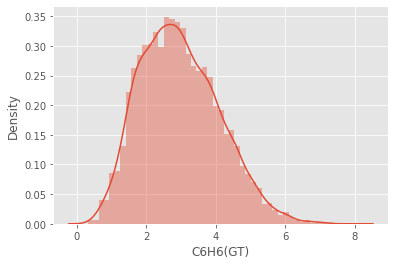

In [ ]:
# Visualization for squre root transformation of target
sns.distplot(sqrt_target)

In [ ]:
#skewness and kurtosis for log transformation
print("Skewness log: %f" % log_target.skew())
print("Kurtosis log: %f" % log_target.kurt())

#skewness and kurtosis for power transformation
print("\nSkewness power: %f" % power_target.skew())
print("Kurtosis power: %f" % power_target.kurt())

#skewness and kurtosis for sqrt transformation
print("\nSkewness sqrt: %f" % sqrt_target.skew())
print("Kurtosis sqrt: %f" % sqrt_target.kurt())

Skewness log: -0.659468
Kurtosis log: 0.613946

Skewness power: 3.914139
Kurtosis power: 25.809274

Skewness sqrt: 0.424398
Kurtosis sqrt: -0.132982


* As it is visible from histogram the best transformation for target is squre root, log is on the second place
* As we can see from measurements of skewness and kurtosis the best is sqrt transformation 
* There still will be some outliers but data will be very close to normal distribution with the smallest skewness and kurtosis
* Transformation will be done here, dealing with outliers in next section

In [ ]:
# Transforming actual values for target variable with squre root
df['C6H6(GT)'] = sqrt_target

### 3.2. Numerical features

Let's check distributions of numerical features.

Also boxplot to check relations of numerical features with year to see if there is any dependancy.

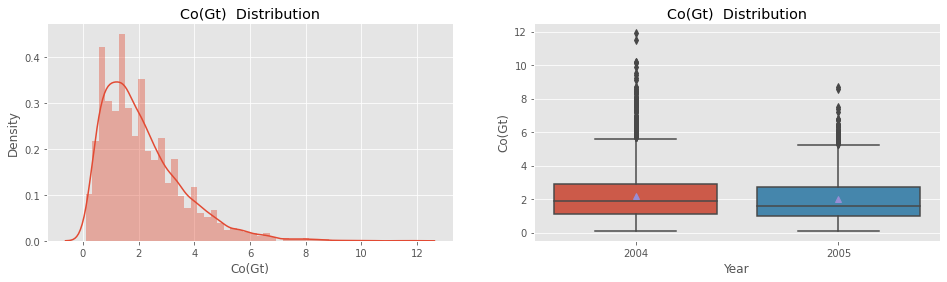

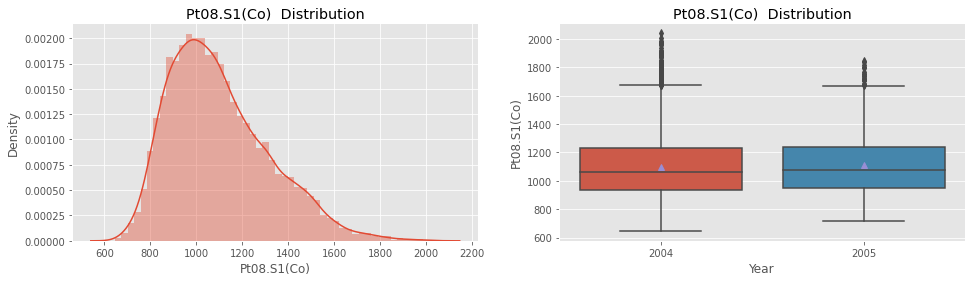

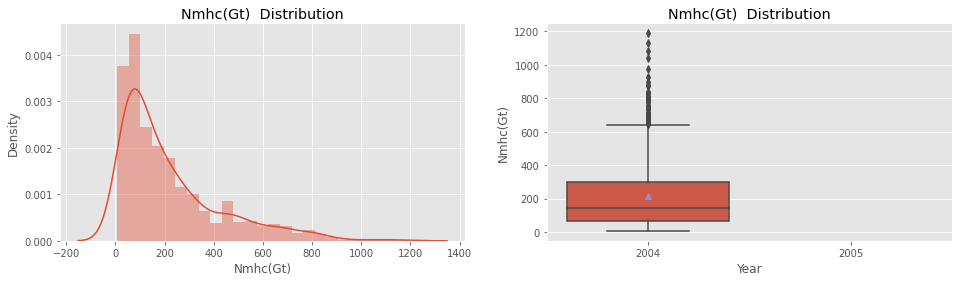

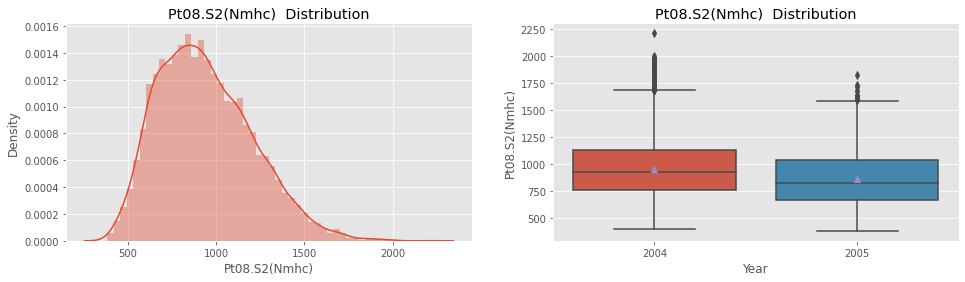

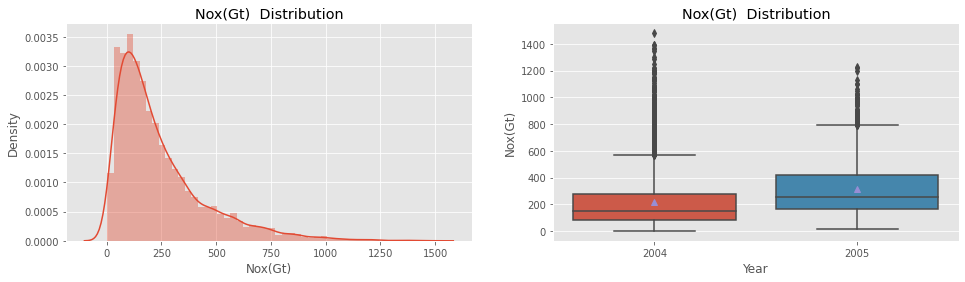

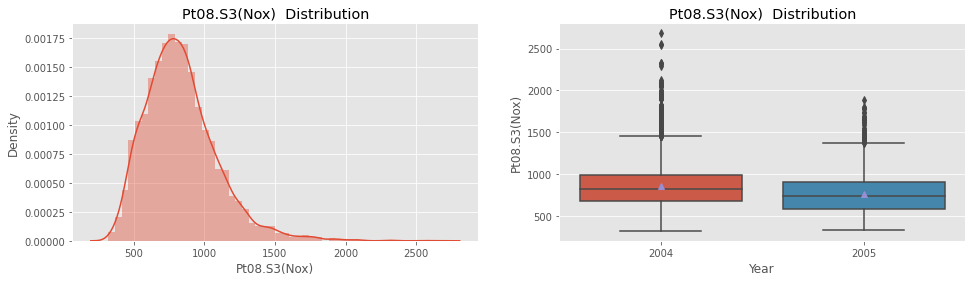

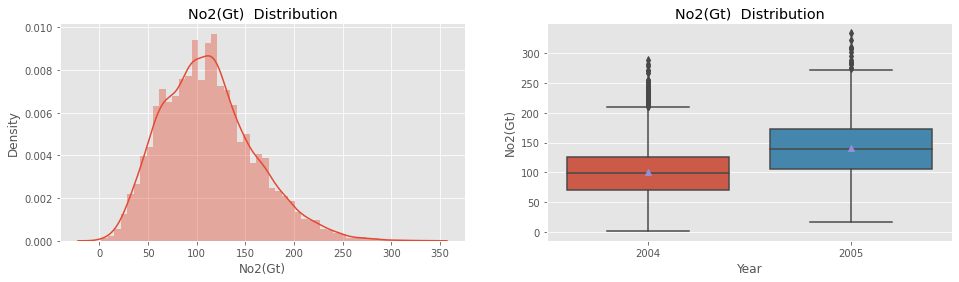

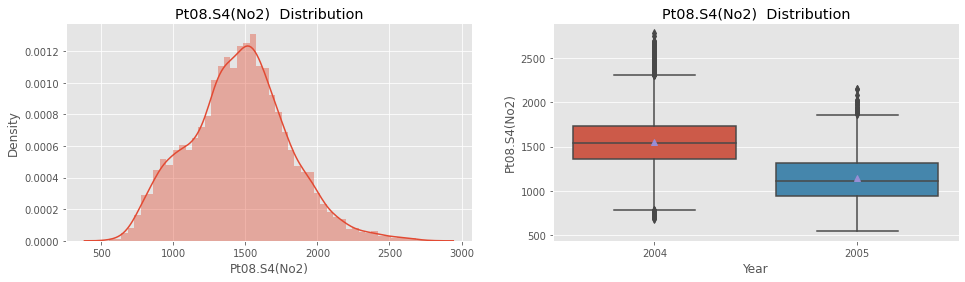

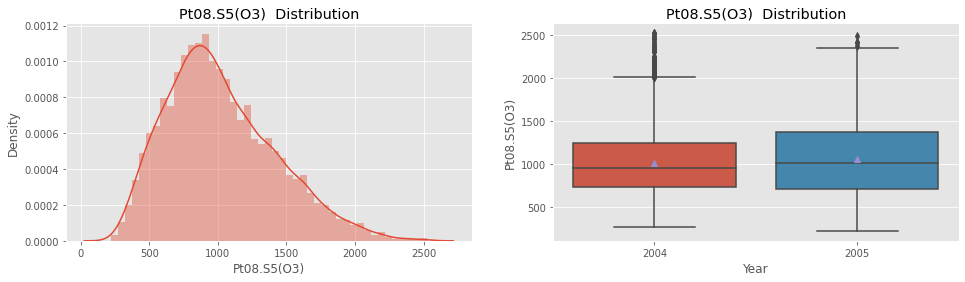

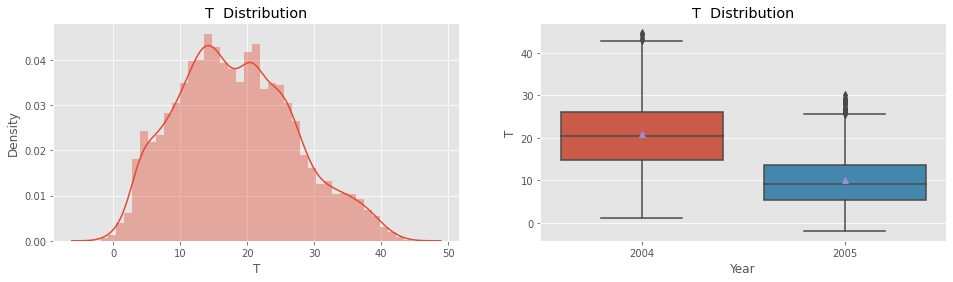

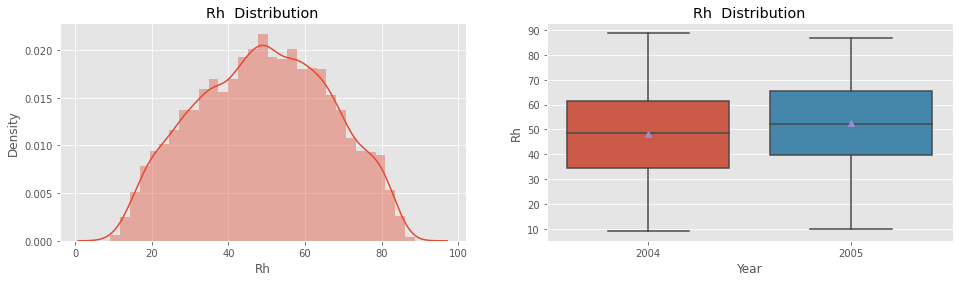

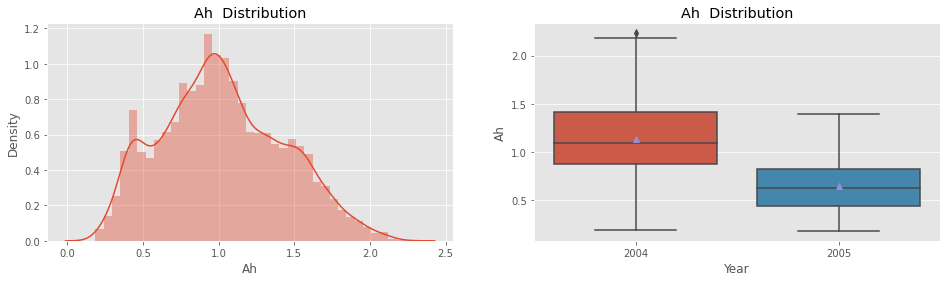

In [ ]:
# Visualization for numerical features distributions separately and with Year feature
num_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

for column in num_columns:

    plt.figure(figsize=(16,4))

    plt.subplot(1,2,1)
    sns.distplot(df[column])
    plt.xlabel(column.title())
    plt.ylabel('Density')
    plt.title(f'{column.title()}  Distribution')

    plt.subplot(1,2,2)
    sns.boxplot(x='Year', y=column, data=df, showmeans=True )
    plt.xlabel('Year')
    plt.ylabel(column.title())
    plt.title(f'{column.title()}  Distribution')

* From visualization we can see that almost for every feature there are ouliers and they need to be handled. Will be done in next section
* Biggest part of features have not normally distributed data
* CO(GT), PT08.S1(CO), NMHC(GT), NOx(GT), PT08.S3(NOx) and NO2(GT) have obviously positive skew and may be some kind of transformation should be considered for them, like log or squre root
* For NMHC(GT) there is no data for 2005 year, percentage of NaN values should be checked here, post probably that's the reason
* For most of features values are slightly bigger in 2004 year and smaller in 2005 year, espessially for PT08.S4(NO2), T and AH
* For some features like NOx(GT) and NO2(GT) values in 2004 are smaller then values in 2005


### 3.3. Categorical features

Despite Hour, Month and Year have integer datatype but they are categorical by the nature. 

Let's check their distributions.

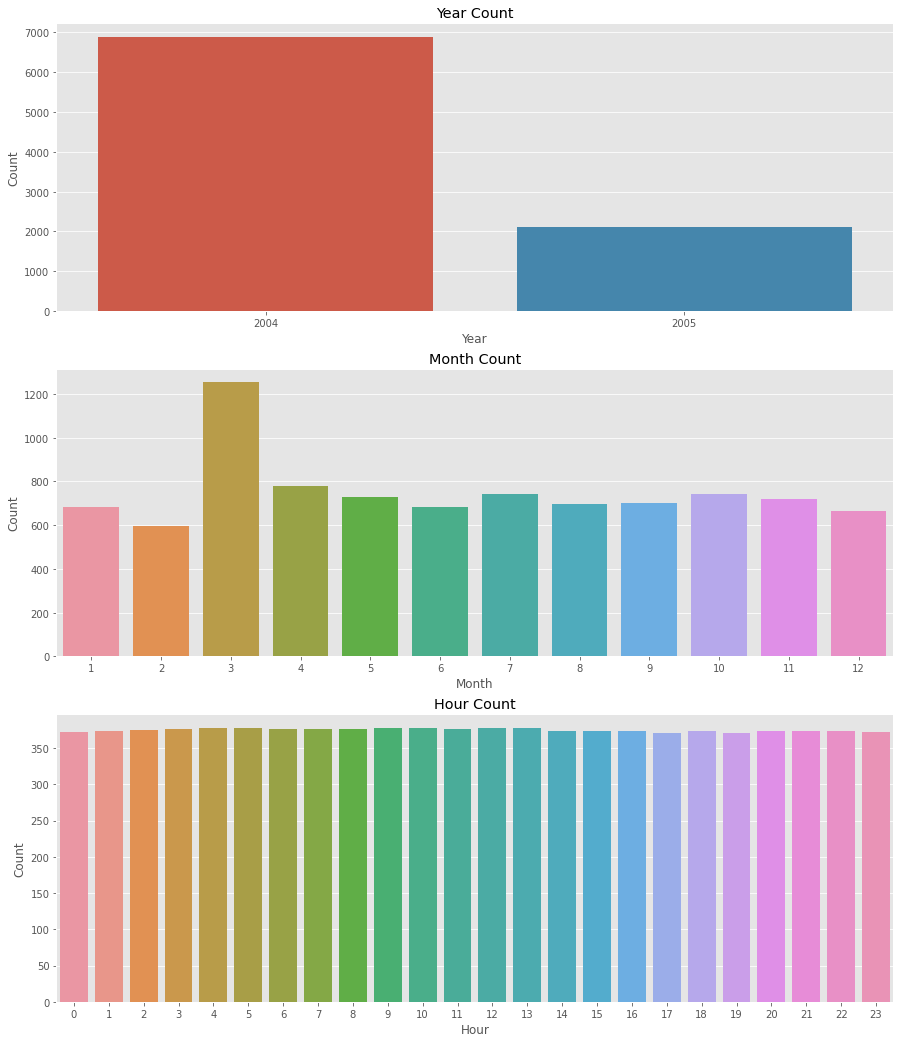

In [ ]:
# Visualization for categorical features
plot3('Year', 'Month', 'Hour')

* For Year feature most of records are done in 2004 year, and much less in 2005
* For Month feature February has the smallest amount of records and March the biggest, others are pretty the same
* For Hour feature we observe uniform distribution, the same amount of records for every hour

## 4. Multivariate analysis

### 4.1. Target vs categorical features relations

Text(0.5, 1.0, 'Year vs Target')

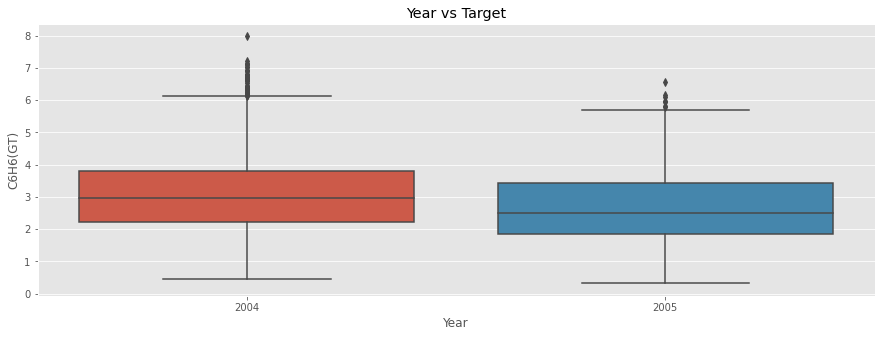

In [ ]:
# Visualization for target variable and Year relations
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x = "Year", y = "C6H6(GT)", data = df, orient = 'v')
ax.set_title("Year vs Target")

Text(0.5, 1.0, 'Month vs Target')

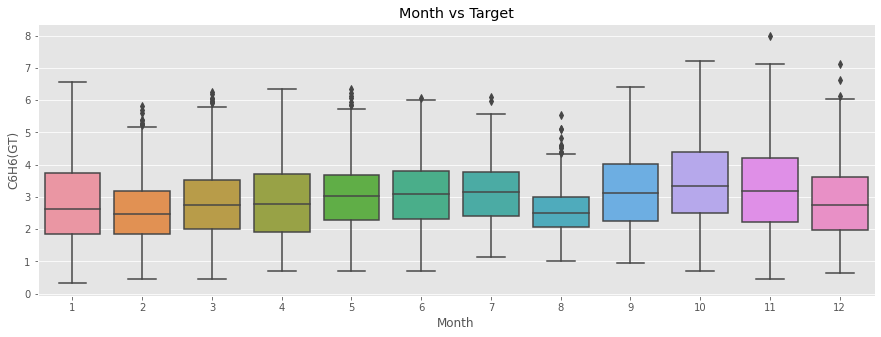

In [ ]:
# Visualization for target variable and Month relations
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x = "Month", y = "C6H6(GT)", data = df, orient = 'v')
ax.set_title("Month vs Target")

Text(0.5, 1.0, 'Hour vs Target')

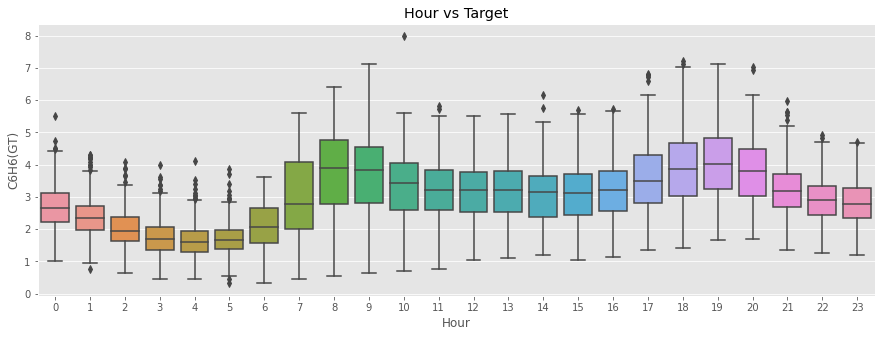

In [ ]:
# Visualization for target variable and Hour relations
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x = "Hour", y = "C6H6(GT)", data = df, orient = 'v')
ax.set_title("Hour vs Target")

* For 2004 year target is slightly higher then for 2005 but difference is very small
* In August target has the lowest value and in October the highest
* The bigger difference in target values is for Hour feature. We can see that during night values are small and then the biggest are in the morning 8-9 hours and in the evening 18-19 hours. So this feature definitely affects target variable.

### 4.2. Numerical features relations including target

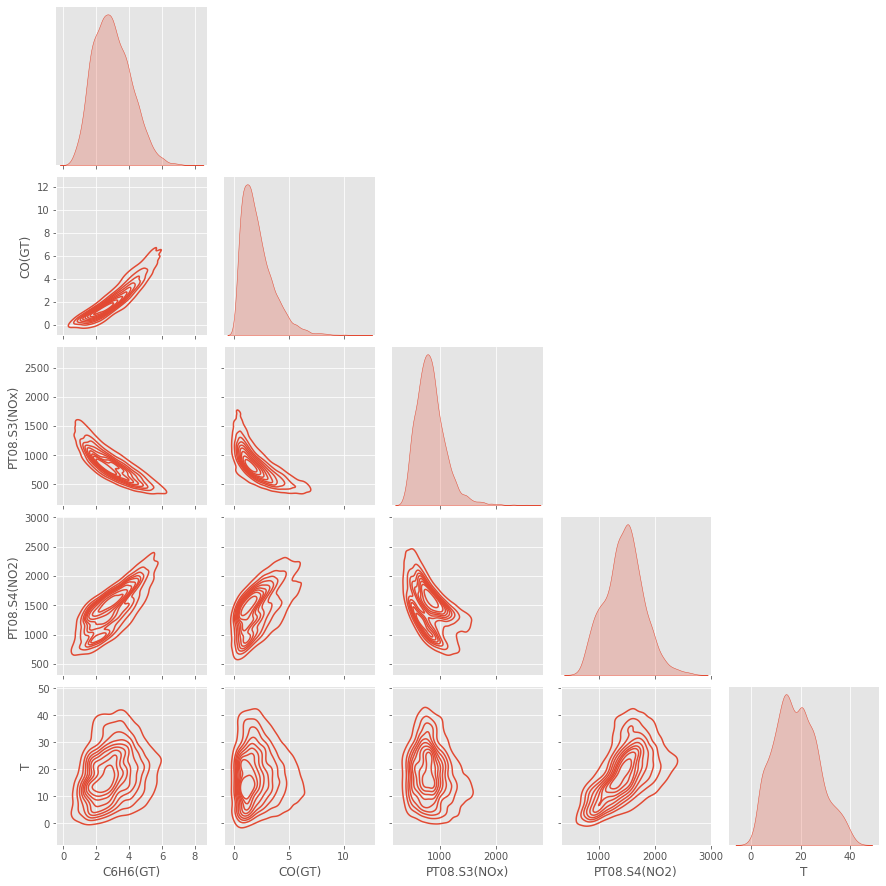

In [ ]:
# Visualization for target vs some numerical features relations
num_columns_some = ['C6H6(GT)', 'CO(GT)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'T']
sns.pairplot(
    df,
    x_vars=num_columns_some,
    y_vars=num_columns_some,
    corner=True,
    kind="kde"
)

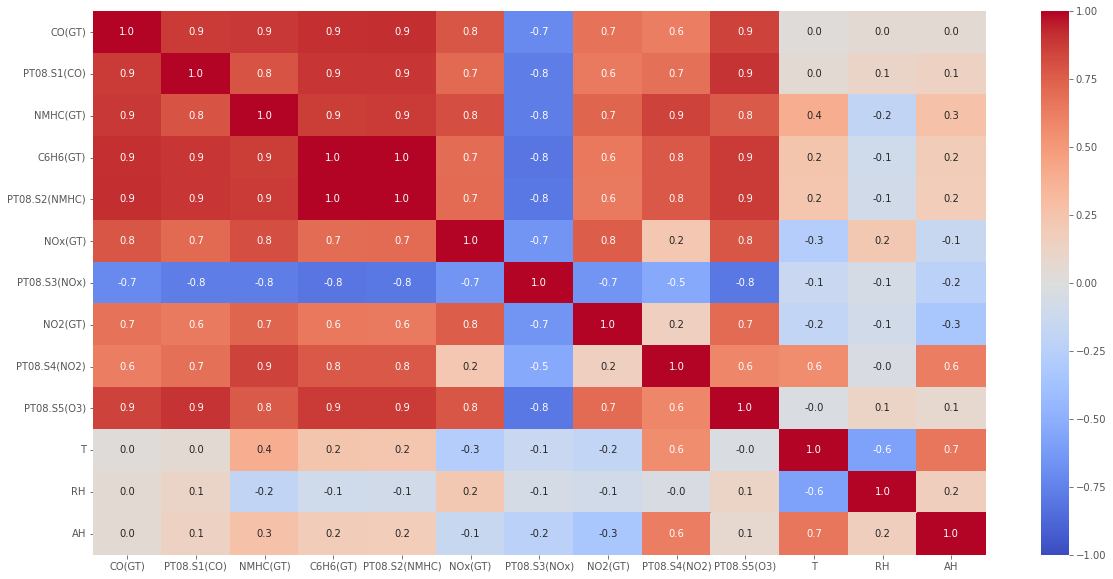

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(df.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='coolwarm')

* As we can see from pairplot and heatmap there are bunch of features wich are highly correlated 
* We need to drop some of them to avoid multicollinearity problem
* For PT group of features next one will be dropped: PT08.S1(CO), PT08.S2(NMHC), PT08.S5(O3) and PT08.S3(NOx), PT08.S4(NO2) will be left.
* Target variable has strong negative correclation with PT08.S3 feature and positive wiht PT08.S4 feature
* For GT group of features NOx will be dropped to decrease multicollinearity,  and we have NOx measurement in PT08.S3(NOx), information from description
* NMHC(GT) most probably has big amount of nulls, so it will be decided in next section if dropping is needed here
* For T, AH, RH group of features RH will be dropped as we know from description that AH and RH is the same just relative and absolute. 


In [ ]:
# Dropping features after analysis 
df.drop('PT08.S1(CO)', axis=1, inplace=True)
df.drop('PT08.S2(NMHC)', axis=1, inplace=True)
df.drop('PT08.S5(O3)', axis=1, inplace=True)
df.drop('NOx(GT)', axis=1, inplace=True)
df.drop('RH', axis=1, inplace=True)

In [ ]:
# Correlation for target variable
df.corr()['C6H6(GT)'].sort_values()

PT08.S3(NOx)   -0.805781
AH              0.190446
T               0.248589
NO2(GT)         0.649572
PT08.S4(NO2)    0.776522
NMHC(GT)        0.869556
CO(GT)          0.909028
C6H6(GT)        1.000000
Name: C6H6(GT), dtype: float64

* Looks like the most interesting features for target are **CO, NMHC** and **PT08.S3**, but more investigation needed

## 5. Data preparation

Some useful functions before the section

In [ ]:
# Function for sqrt data transformation
def transform_data(column):
    column = np.sqrt(column)
    return column

In [ ]:
# Function for deleting rows with outliers due to 1.5IQR rule
def drop_outliers(data, column):
    Q1, Q3 = np.percentile(column,[25,75])
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5*IQR)
    upper_limit = Q3 + (1.5*IQR)
    df.drop(df[column<lower_limit].index, inplace=True)
    df.drop(df[column>upper_limit].index, inplace=True)
    print('Outliers deleted')

### 5.1. Missing values

Now will check whare we have missing values

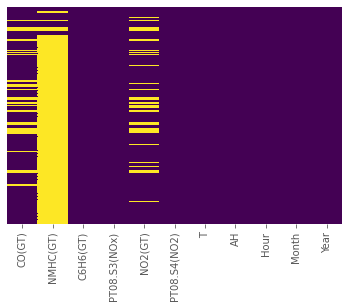

In [ ]:
# Visualization for missing values
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In [ ]:
# Percentage of missing values for each feature
df.isna().sum()/len(df)

CO(GT)          0.183183
NMHC(GT)        0.901346
C6H6(GT)        0.000000
PT08.S3(NOx)    0.000000
NO2(GT)         0.177733
PT08.S4(NO2)    0.000000
T               0.000000
AH              0.000000
Hour            0.000000
Month           0.000000
Year            0.000000
dtype: float64

* As we can see NMHC has very big amount of missing values so it will be dropped.
* For CO and NO2 missing values will be filled with median in pipeline in next section

In [ ]:
# Dropping NMHC feature
df.drop('NMHC(GT)', axis=1, inplace=True)

### 5.2. Outliers

In [ ]:
# Statistics for numerical features
df.describe()

,CO(GT),C6H6(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),T,AH
count,7344.000000,8991.000000,8991.000000,7393.000000,8991.000000,8991.000000,8991.000000
mean,2.129711,2.966725,835.493605,112.145137,1456.264598,18.317829,1.025530
std,1.436472,1.132163,256.817320,47.629141,346.206794,8.832116,0.403813
min,0.100000,0.316228,322.000000,2.000000,551.000000,-1.900000,0.184700
25%,1.100000,2.097618,658.000000,77.000000,1227.000000,11.800000,0.736800
50%,1.800000,2.863564,806.000000,109.000000,1463.000000,17.800000,0.995400
75%,2.800000,3.741657,969.500000,140.000000,1674.000000,24.400000,1.313700
max,11.900000,7.981228,2683.000000,333.000000,2775.000000,44.600000,2.231000


* As we can see almost for every feature we have ouliers
* For dropping them we select method with 1.5(IQR) as it deletes extreme values, but still left pretty much rows which can be useful for other features

In [ ]:
# Deleting extreme outliers
drop_outliers(df, df['PT08.S4(NO2)'])
drop_outliers(df, df['C6H6(GT)'])
drop_outliers(df, df['CO(GT)'])
drop_outliers(df, df['PT08.S3(NOx)'])
drop_outliers(df, df['NO2(GT)'])
drop_outliers(df, df['T'])
drop_outliers(df, df['AH'])

Outliers deleted
Outliers deleted
Outliers deleted
Outliers deleted
Outliers deleted
Outliers deleted
Outliers deleted


### 5.3. Transformation, imputing and scaling

First we need to separate numerical, categorical and target columns

In [ ]:
NUMERICAL_FEATURES = [ 
    'PT08.S3(NOx)',
    'PT08.S4(NO2)',
    'NO2(GT)',
    'T',
    'AH',
    'CO(GT)'

]
CATEGORICAL_FEATURES = [
    'Hour',
    'Month',
    'Year'
]
TARGET = ['C6H6(GT)']
SEED = 42

In [ ]:
# Encoding ordinal categorical features
df[CATEGORICAL_FEATURES] = df[CATEGORICAL_FEATURES].apply(lambda x: x.cat.codes)

In [ ]:
# copy our data to new train dataframe
train = df

From univariate analysis of numerical features we saw that some of them need to be transformed due to some skewness. Good way to do it with squre root transformation.

In [ ]:
# Skewed features transformation 
train['PT08.S3(NOx)'] = transform_data(train['PT08.S3(NOx)'])
train['NO2(GT)'] = transform_data(train['NO2(GT)'])
train['CO(GT)'] = transform_data(train['CO(GT)'])

In [ ]:
# Using gen_features function to impute missing values and scale numerical data
# Numerical
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL_FEATURES],
    classes=[
        {'class': SimpleImputer, 'strategy': 'median'},
        {'class': StandardScaler}
    ]
)
# Ordinal
ordinal_def = gen_features(
    columns=[[c] for c in CATEGORICAL_FEATURES],
    classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'}
    ]
)

In [ ]:
# Using mapper for transformation
features = numerical_def + ordinal_def
mapper = DataFrameMapper(features)
len(features)

9

## 6. Linear Regression

Some useful functions to be used in the section

In [ ]:
# Function for residual analysis
def residual_analysis(X, y, model):
  pred = model.predict(X)
  errors = y - pred

  plt.scatter(list(range(len(errors))),errors);
  plt.title("Distibution of errors")
  plt.ylabel('Error');
  plt.xlabel('Index');
  plt.show();

  plt.scatter(pred,errors);
  plt.title('Relationship of true value vs error (residual analysis)')
  plt.ylabel('Error');
  plt.xlabel('True value');
  plt.show();

In [ ]:
# Helper function to get score of the model
def get_score(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [ ]:
# Function for cross validation with TimeSeriesSplit
def cv_with_ts(ts_cv):
  for tr_index, val_index in ts_cv.split(train_X_tr):
      X_tr = pd.DataFrame(train_X_tr)
      y_tr = pd.DataFrame(train_y_tr)
      X_tr, X_val = X_tr.iloc[tr_index], X_tr.iloc[val_index]
      y_tr, y_val = y_tr.iloc[tr_index], y_tr.iloc[val_index]
      print(get_score(linreg, X_tr, X_val, y_tr, y_val))

### 6.1. Linear regression baseline

In [ ]:
# Splitting values to train and validation sets with 20% of data for validation
target = train[TARGET].values
train_X, val_X, train_y, val_y = train_test_split(train.drop(TARGET, axis=1), target, 
                                                  random_state=SEED, shuffle=True, test_size = 0.2)

In [ ]:
# Transforming X variables
train_X_tr = pd.DataFrame(mapper.fit_transform(train_X))
val_X_tr = pd.DataFrame(mapper.transform(val_X))

In [ ]:
# Target variable was already transformed so just renaming for consistency
train_y_tr = train_y
val_y_tr = val_y

In [ ]:
# Linear regression modeling with the R2 and adjusted R2 score on validation data
linreg = LinearRegression()
linreg.fit(train_X_tr, train_y_tr)
print(f'\nR2 Score: {linreg.score(val_X_tr, val_y_tr)}')



R2 Score: 0.9579357354333874


In [ ]:
f=linreg.fit(train_X_tr, train_y_tr)
f

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We can see that R2 looks good, but it would be correct to check some metrics and to see if we can improve our model

### 6.2. Metrics

Now we can check some metrics, next one were selected:
1. **RMSE**:
    * it does account for positive or negative value
    * is better in terms of reflecting performance when dealing with large error values then MSE
    * it is not squared and not scaled so we explicitly know how much our predictions deviate 
2. **MAE**: 
    * despite we handled extreme outliers but some could left, so this metric can be used just for confirmation
3. **R2**:
    * is the fraction of the total sum of squares that is explained by the regression
    * can be easily interpreted compare to RMSE as it is conveniently scaled between 0 and 1
4. **Residual analysis** 
    * visualization to check if linear model is a good fit for our data


In [ ]:
# Function to evaluate the model with listed metrics
def evaluate_model(train, val, tr_y, val_y, model):
    model.fit(train, tr_y)
    pred_val = model.predict(val)
    pred_train = model.predict(train)

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'train_MAE': [mean_absolute_error(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)],
        'val_MAE': [mean_absolute_error(val_y, pred_val)]
    }), mapper.transformed_names_

In [ ]:
# Metrics for the model
scores, _ = evaluate_model(train_X_tr, val_X_tr, train_y_tr, val_y_tr, linreg)
scores

,train_RMSE,train_R2,train_MAE,val_RMSE,val_R2,val_MAE
0,0.203308,0.962472,0.156895,0.217143,0.957936,0.159095


* So for baseline we can see that difference between metrics is not big for train and validation sets
* Also no regularization will be used as it doesn't look we have overfitting here because metrics are not differ a lot for train and validation sets

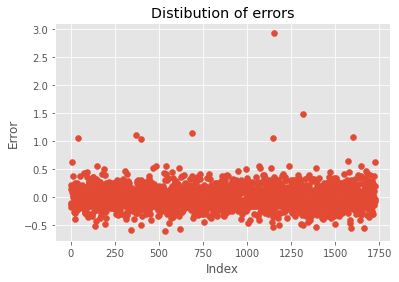

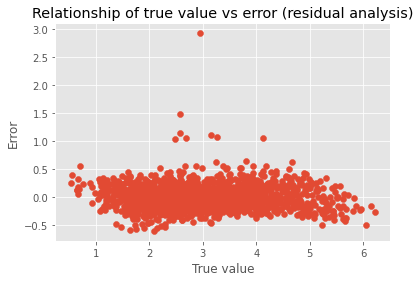

In [ ]:
# Errors visualization for better understanding behavior of the model
residual_analysis(val_X_tr, val_y_tr, linreg)

* From this visulization we can see that errors are located around 0 which is good
* But still there are few outliers which can be handled to improve our model
* For now linear regression model looks enough good for our data, but more investigation needed may be towards polynomial regression

### 6.3. Cross validation

As we have time and date type of values in our dataset we need to use TimeSeriesSplit instead of KFold to have validation split always in the end

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Cross validation for the model
cv_with_ts(tscv)

0.9625061380804346
0.9638107147937474
0.9624539821804632
0.9645794217363842
0.9635119753990355


* During cross validation model scores are very close to each other which confirms that our model is working correct for different splits

Now let's check which one features have the biggest weight in our model

In [ ]:
weights = pd.DataFrame(np.abs(linreg.coef_))
weights.columns = train_X.columns
weights

,CO(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),T,AH,Hour,Month,Year
0,0.391857,0.82579,0.048426,0.057185,0.490986,0.089621,0.006095,0.068214,0.308441


* We can see that **3 features** have the biggest weight: **PT08.S3(NOx), T and CO(GT)**

## Conclusion:
* Linear regression is good model for our data, it works effective on test data, but also some additional investigation can be done, may be even towards polynomial featuring
* The most important features for our model are: PT08.S3(NOx), T and CO(GT)

In [ ]:
list1 = [2, 3, 4, 5, 6, 7]

In [ ]:
list1[-5:]

[3, 4, 5, 6, 7]